# Table of Contents
1. Problem Definition
2. Load Data and Split Data for train and test
3. Exploring Data Analysis
   - 3.1 Descriptive Analysis
   - 3.2 Data Visualisation
4. Data Preparation
5. Select and Train Models
6. Model Evaluation
7. Finalise Model and Predict
   - 7.1 Finalise Model
   - 7.2 Make Prediciton
   - 7.3 Save prediction into a csv filezip file.



# 1. Project Definition
This project aims to develop an AI-enhanced fall detection system to address the significant risks falls pose to the elderly in homes and care facilities.  By integrating machine learning algorithms with sensor data and possible computer vision, the project seeks to detect falls in real time and automatically alert caregivers or emergency services.  Using AI/ML techniques is central to providing rapid response and potentially life-saving intervention, enhancing the safety and quality of life for older adults by leveraging technology advancements in fall detection.

In [65]:
# 2. Load data and Split Data for Train and Test
import pandas as pd

# Load dataset containing sensor and health data relevant for fall detection
df = pd.read_csv('datasets/originaldataset.csv')

# Print column names to understand the dataset structure
print(df.columns)

Index(['Distance', 'Pressure', 'HRV', 'Sugar level', 'SpO2', 'Accelerometer',
       'Decision'],
      dtype='object')


# 3. Exploring Data Analysis

In [66]:
# 3.1 Descriptive Analysis
# Display descriptive statistics of the dataset
print(df.describe())

          Distance     Pressure          HRV  Sugar level         SpO2  \
count  2039.000000  2039.000000  2039.000000  2039.000000  2039.000000   
mean     28.694527     0.988720    95.657002    72.909243    83.563649   
std      23.773644     0.815918    17.576499    46.940110    11.111592   
min       0.000000     0.000000    60.000000    10.000000    60.000000   
25%       7.642500     0.000000    82.418000    40.230000    75.285000   
50%      20.560000     1.000000    97.238000    69.960000    85.280000   
75%      55.205500     2.000000   109.695000    77.612500    92.692500   
max      69.981000     2.000000   124.980000   179.293000    99.990000   

       Accelerometer     Decision  
count    2039.000000  2039.000000  
mean        0.661599     0.988720  
std         0.473282     0.815918  
min         0.000000     0.000000  
25%         0.000000     0.000000  
50%         1.000000     1.000000  
75%         1.000000     2.000000  
max         1.000000     2.000000  


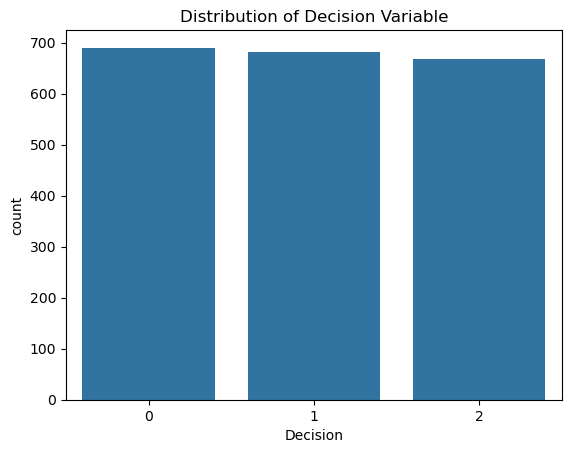

In [67]:
# 3.2 Data Visualisation
# Visualise the distribution of the 'Decision' variable to understand the balance or imbalance between fall and non-fall instances.

import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Decision', data=df)
plt.title('Distribution of Decision Variable')
plt.show()

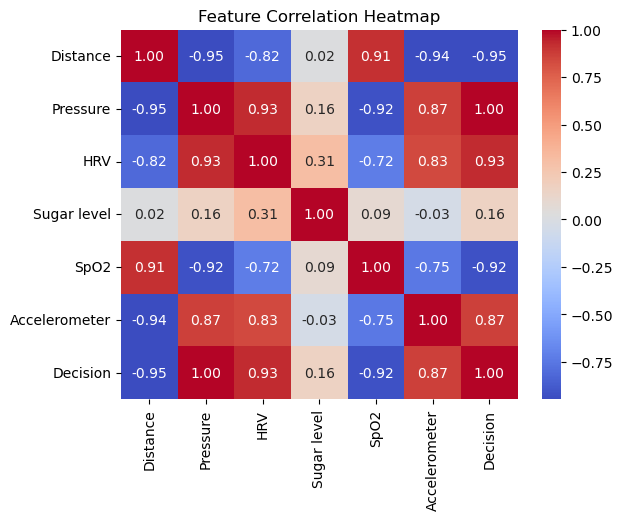

In [68]:
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


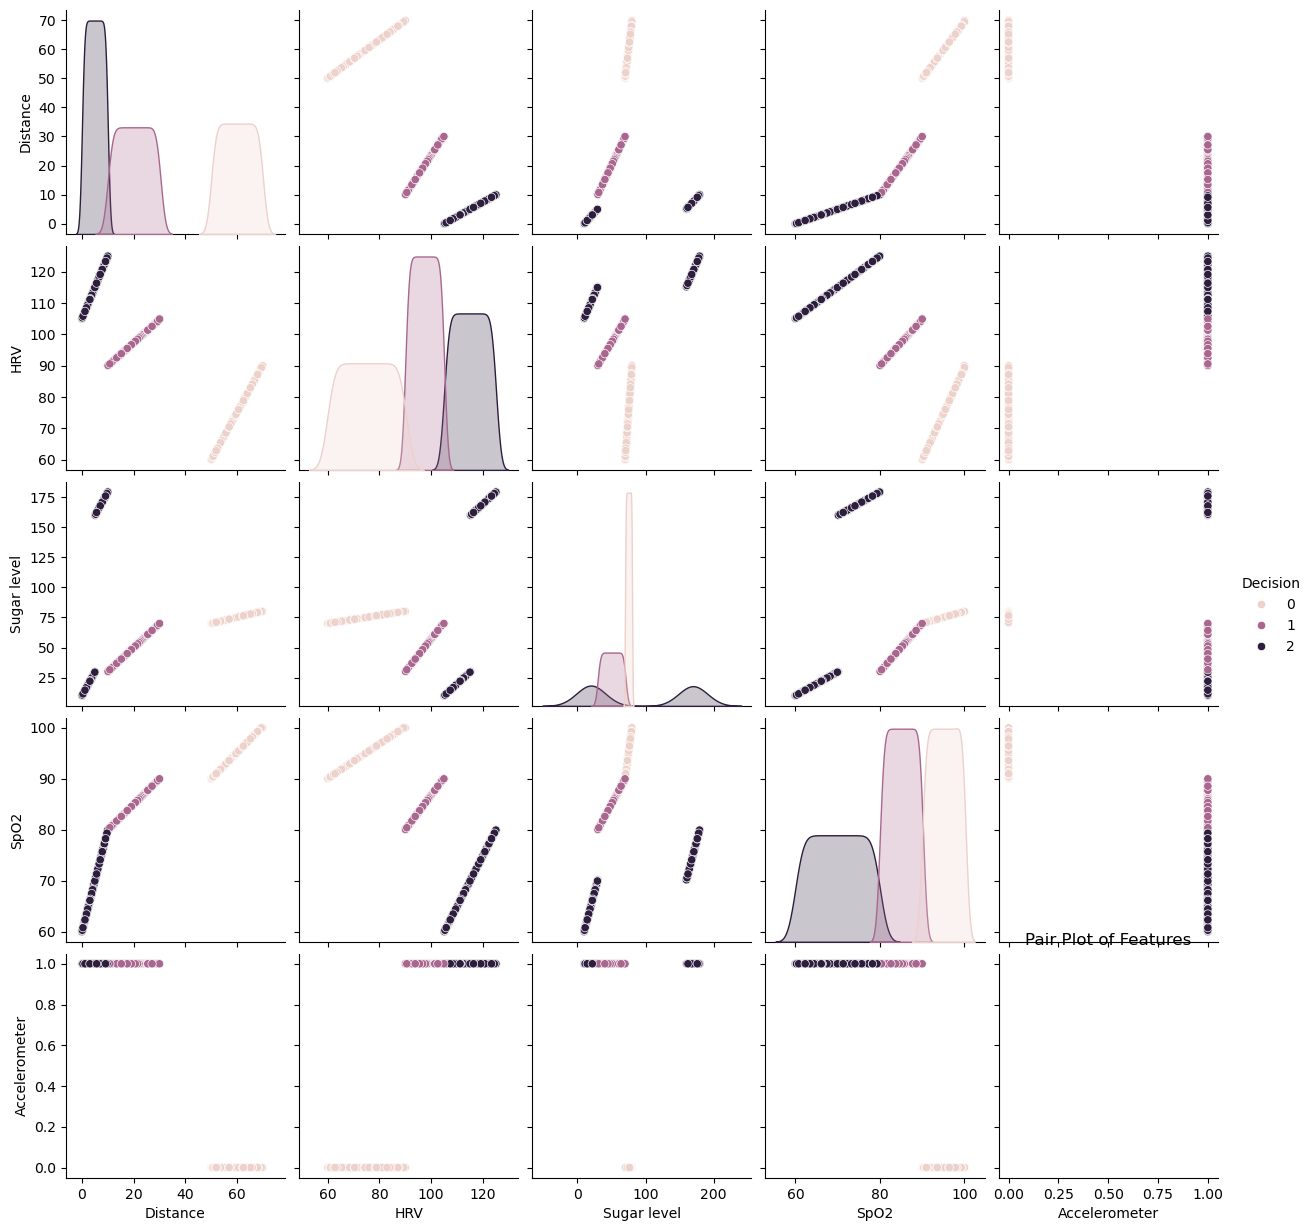

In [69]:
# Select a subset of features for clarity
features = numeric_features + ['Decision']
sns.pairplot(df[features], hue='Decision')
plt.title('Pair Plot of Features')
plt.show()


# 4. Data Preparation

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define numeric and categorical features
numeric_features = ['Distance', 'HRV', 'Sugar level', 'SpO2', 'Accelerometer']
categorical_features = ['Pressure']

# Create transformers
# Numeric transformer pipeline for handling missing values and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())]) 

# Categorical transformer pipeline for handling missing values and applying one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) 

# Combining preprocessing steps into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # Apply numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features)]) # Apply categorical transformer to categorical features

# 5. Select and Train Models

In [71]:
# Train Random Forest and Gradient Boosting models.
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

# Prepare the data
X = df.drop('Decision', axis=1)
y = df['Decision']

# Define model pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1_score': 'f1_weighted'
}

# Define scoring metrics
cv_strategy = StratifiedKFold(n_splits=5)

# Perform cross-validation
cv_results_rf = cross_validate(rf_pipeline, X, y, cv=cv_strategy, scoring=scoring)
cv_results_gb = cross_validate(gb_pipeline, X, y, cv=cv_strategy, scoring=scoring)


In [79]:
def get_feature_names(column_transformer):
    """Generate feature names from a ColumnTransformer instance."""
    feature_names = []
    
    # Loop through each transformer within the ColumnTransformer
    for transformer in column_transformer.transformers_:
        transformer_name, transformer_obj, transformer_columns = transformer
        
        # Handle case for transformers applied to columns
        if transformer_name != 'remainder':
            if hasattr(transformer_obj, 'get_feature_names_out'):  # For transformers with this method
                names = transformer_obj.get_feature_names_out(transformer_columns)
                feature_names.extend(names)
            elif hasattr(transformer_obj, 'categories_'):  # For OneHotEncoder without get_feature_names_out
                names = []
                for i, column in enumerate(transformer_columns):
                    categories = transformer_obj.categories_[i]
                    names.extend([f"{column}_{category}" for category in categories])
                feature_names.extend(names)
            else:  # Transformers without a method to get feature names
                feature_names.extend(transformer_columns)
                
    return feature_names


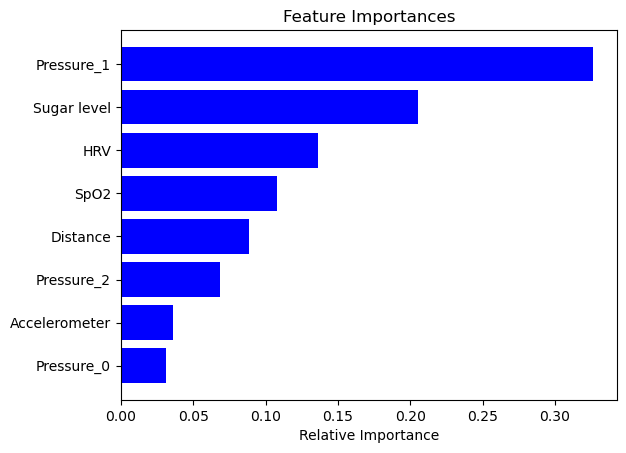

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure you have called the get_feature_names function correctly to get feature_names
feature_names = get_feature_names(final_model.named_steps['preprocessor'])
importances = final_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')

# Corrected: Use feature_names for labeling, not X.columns
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')
plt.show()


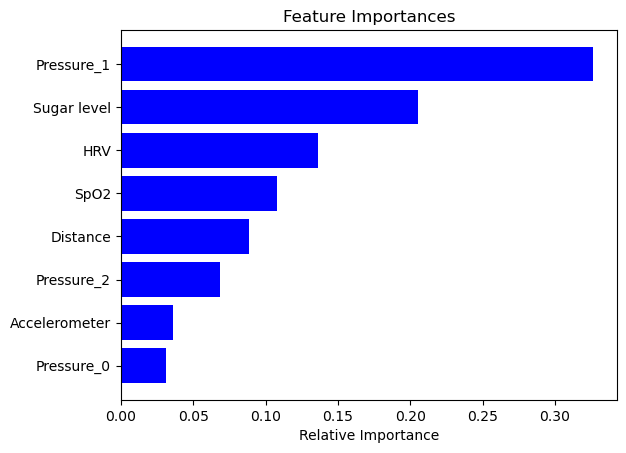

In [74]:
# Assuming you have a trained model named final_model
importances = final_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# 6. Model Evaluation

In [75]:
# Print average scores
print(f"Random Forest Average CV Accuracy: {np.mean(cv_results_rf['test_accuracy'])}")
print(f"Gradient Boosting Average CV Accuracy: {np.mean(cv_results_gb['test_accuracy'])}")

#

Random Forest Average CV Accuracy: 1.0
Gradient Boosting Average CV Accuracy: 1.0


In [76]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted')}

# Use StratifiedKFold for balanced folds
cv_strategy = StratifiedKFold(n_splits=5)

# Cross-validation for Random Forest
cv_results_rf = cross_validate(rf_pipeline, X, y, cv=cv_strategy, scoring=scoring)
print("Random Forest CV Results:")
print(f"Accuracy: {np.mean(cv_results_rf['test_accuracy'])} ± {np.std(cv_results_rf['test_accuracy'])}")
print(f"Precision: {np.mean(cv_results_rf['test_precision'])}")
print(f"Recall: {np.mean(cv_results_rf['test_recall'])}")
print(f"F1 Score: {np.mean(cv_results_rf['test_f1_score'])}")

# Cross-validation for Gradient Boosting
cv_results_gb = cross_validate(gb_pipeline, X, y, cv=cv_strategy, scoring=scoring)
print("\nGradient Boosting CV Results:")
print(f"Accuracy: {np.mean(cv_results_gb['test_accuracy'])} ± {np.std(cv_results_gb['test_accuracy'])}")
print(f"Precision: {np.mean(cv_results_gb['test_precision'])}")
print(f"Recall: {np.mean(cv_results_gb['test_recall'])}")
print(f"F1 Score: {np.mean(cv_results_gb['test_f1_score'])}")


Random Forest CV Results:
Accuracy: 1.0 ± 0.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Gradient Boosting CV Results:
Accuracy: 1.0 ± 0.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [77]:
print(y.unique())

# Convert to binary classification: 1 vs. 0/2
y_binary = (y == 1).astype(int)  # This makes class 1 as '1' and classes 0 and 2 as '0'

# Now you can split your data
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Proceed with your model training and ROC curve plotting using y_train_binary and y_test_binary



[1 2 0]


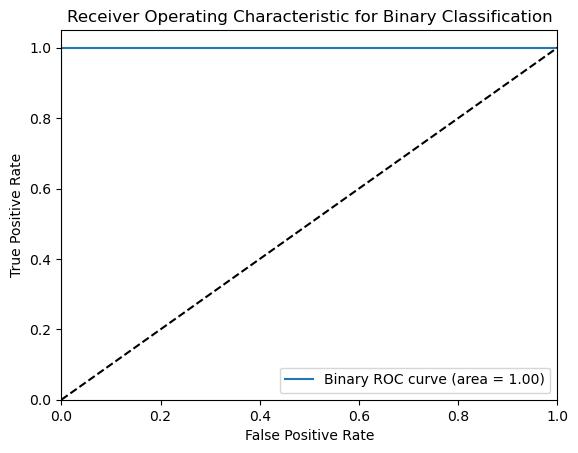

In [62]:
from sklearn.metrics import roc_curve, auc

# Assuming final_model is ready and y_binary is your binary target variable
model = final_model.fit(X_train, y_train_binary)

# Predict probabilities for the positive class (class '1' in this binary scenario)
y_score_binary = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the binary classification
fpr_binary, tpr_binary, _ = roc_curve(y_test_binary, y_score_binary)
roc_auc_binary = auc(fpr_binary, tpr_binary)

# Plotting for binary classification
plt.figure()
plt.plot(fpr_binary, tpr_binary, label='Binary ROC curve (area = %0.2f)' % roc_auc_binary)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Binary Classification')
plt.legend(loc="lower right")
plt.show()



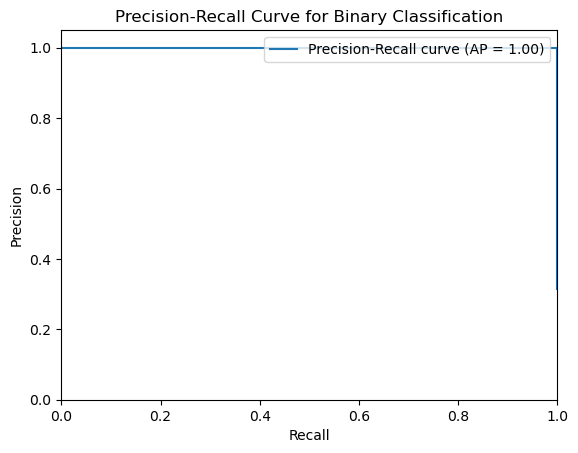

In [78]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Ensure this uses the binary classification outputs and targets
y_score_binary = model.predict_proba(X_test)[:, 1]  # Model predictions for the positive class

# Compute Precision-Recall curve and average precision for the binary classification
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_score_binary)
average_precision = average_precision_score(y_test_binary, y_score_binary)

# Plot the Precision-Recall curve
plt.figure()
plt.step(recall, precision, where='post', label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Binary Classification')
plt.legend(loc="upper right")
plt.show()



# 7. Finalise Model and Predict

In [19]:
# Assuming Random Forest performed better based on CV
final_model = rf_pipeline.fit(X, y)
final_predictions = final_model.predict(X)

final_predictions_df = pd.DataFrame(final_predictions, columns=['Predicted_Fall'])
final_predictions_df.to_csv('datasets/test2_final_predictions.csv', index=False)
